# Disaster Tweets

   * Smartphones enables people to announce an emergency they’re observing in real-time. Since organizations like NGO cannot look for each and every message, they have to use programmatical approach. But there is a problem, there maybe fake message, there maybe words describing a normal situation but the program may consider it as a disaster tweet. If our program can understand our language, it will be a able to separate disaster tweets from normal tweets.
   
   
   * This approach can be used in similar occasions like searching jobs/internship in linked In.
   
  

### In this notebook we will predict whether tweet is about a real disaster or not on the basis of a kaggle dataset.

WE WILL BE DOING TEXT PREPROCESSING AND THEN WE WILL USE RANDOM-FOREST CLASSIFIER AND NAIVE BAYES CLASSIFIER FOR THE PURPOSE OF CLASSIFICATION.

WE WILL USE BOTH 'BAG OF WORDS MODEL' AND 'TF-IDF VECTORIZER' TO CONVERT TEXT INTO VECTORS.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Reading training data
train_data = pd.read_csv('train.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_data.shape

(7613, 5)

In [4]:
train_data.id.nunique()

7613

### Since all the ids are unique, we wont get any useful information from it. So lets drop it.

In [5]:
train_data = train_data.drop('id', axis=1)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 238.0+ KB


In [7]:
train_data.location.nunique()

3341

#### There are large number of locations in the dataset and if the locations in the dataset is ocurring only once or twice, we wont get anything useful.

### why I am thinking location is useful??
### Its because maybe the location is more prone to natural calamities. For example hills, areas near to river, forests(wildfire). 

#### So I am considering locations that are repeated atleast 10 times

In [8]:
val_locations = []
for i,j in train_data.location.value_counts().iteritems():
    if j > 10 : 
        val_locations.append(i)
        
val_locations

['USA',
 'New York',
 'United States',
 'London',
 'Canada',
 'Nigeria',
 'UK',
 'Los Angeles, CA',
 'India',
 'Mumbai',
 'Washington, DC',
 'Kenya',
 'Worldwide',
 'Australia',
 'Chicago, IL',
 'California',
 'Everywhere',
 'California, USA',
 'New York, NY',
 'Florida',
 'San Francisco',
 'United Kingdom',
 'Los Angeles',
 'Washington, D.C.',
 'Indonesia',
 'Toronto',
 'Ireland',
 'NYC',
 'Chicago',
 'San Francisco, CA',
 'Seattle',
 'Earth']

### After seeing the locations that are repeated more than 10 times, it is very generalized locations(country) and not specific cities. 
### Now I think we wont get any useful informations from locations.
### So lets drop it.

In [9]:
train_data = train_data.drop('location', axis=1)

<AxesSubplot:>

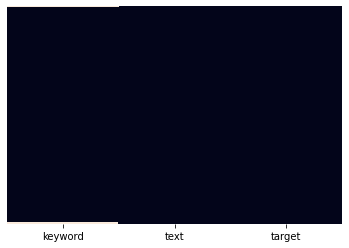

In [10]:
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False)

In [11]:
train_data.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [12]:
val_keys = train_data.keyword.unique()

## Data Preprocessing Required for Text Data

In [13]:
for i,j in train_data['keyword'].iteritems():
    if(not j in val_keys):
        train_data['keyword'][i] = 'random_key'

In [14]:
ps = PorterStemmer()
for i in range(0, train_data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', train_data['keyword'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    train_data['keyword'][i] = review

In [15]:
ps = PorterStemmer()
corpus = []
for i in range(0, train_data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', train_data['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

## NATURAL LANGUAGE PROCESSING
WE WILL BE USING BAG OF WORDS MODEL & TF-IDF VECTORIZER FOR CONVERTING TEXT DATA INTO VECTORS

FOR BOTH RANDOM FOREST CLASSIFIER & NAIVE BAYES CLASSIFIER

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

# CountVectorizer

In [17]:
# Implementing Bag of words model
cv = CountVectorizer(max_features=2500, ngram_range=(2, 2))
X = cv.fit_transform(corpus).toarray()
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Appending it to the main Dataframe
X = pd.concat([train_data, X], axis=1)
X.head()

,keyword,text,target,0,1,2,3,4,5,6,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,random key,Our Deeds are the Reason of this #earthquake M...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,random key,Forest fire near La Ronge Sask. Canada,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,random key,All residents asked to 'shelter in place' are ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,random key,"13,000 people receive #wildfires evacuation or...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,random key,Just got sent this photo from Ruby #Alaska as ...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
y = X['target']
X = X.drop(['text','target'], axis=1)

In [20]:
X = pd.get_dummies(X)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.15,random_state=2020)

print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 2667)
Shape of Validation  (1142, 2667)


### RANDOM FOREST CLASSIFIER

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [22]:
RDclassifier = RandomForestClassifier(random_state=0)
RDclassifier.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [23]:
print(confusion_matrix(y_test,RDclassifier.predict(X_test)))
print(classification_report(y_test,RDclassifier.predict(X_test)))
print(accuracy_score(y_test, RDclassifier.predict(X_test)))

[[546  89]
 [193 314]]
              precision    recall  f1-score   support

           0       0.74      0.86      0.79       635
           1       0.78      0.62      0.69       507

    accuracy                           0.75      1142
   macro avg       0.76      0.74      0.74      1142
weighted avg       0.76      0.75      0.75      1142

0.7530647985989493


### XGBoost

In [24]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[20:44:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
print(confusion_matrix(y_test,xgb.predict(X_test)))
print(classification_report(y_test,xgb.predict(X_test)))
print(accuracy_score(y_test, xgb.predict(X_test)))

[[575  60]
 [239 268]]
              precision    recall  f1-score   support

           0       0.71      0.91      0.79       635
           1       0.82      0.53      0.64       507

    accuracy                           0.74      1142
   macro avg       0.76      0.72      0.72      1142
weighted avg       0.76      0.74      0.73      1142

0.7381786339754816


### MULTINOMIAL NAIVE BAYES

In [26]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)

MultinomialNB()

In [27]:
print(confusion_matrix(y_test,mnb.predict(X_test)))
print(classification_report(y_test,mnb.predict(X_test)))
print(accuracy_score(y_test, mnb.predict(X_test)))

[[553  82]
 [195 312]]
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       635
           1       0.79      0.62      0.69       507

    accuracy                           0.76      1142
   macro avg       0.77      0.74      0.75      1142
weighted avg       0.76      0.76      0.75      1142

0.7574430823117339


# TF-IDF VECTORIZER

In [28]:
tfidf = TfidfVectorizer(max_features=2500)
X = tfidf.fit_transform(corpus).toarray()
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Appending it to the main Dataframe
X = pd.concat([train_data, X], axis=1)
X.head()

,keyword,text,target,0,1,2,3,4,5,6,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,random key,Our Deeds are the Reason of this #earthquake M...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,random key,Forest fire near La Ronge Sask. Canada,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,random key,All residents asked to 'shelter in place' are ...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,random key,"13,000 people receive #wildfires evacuation or...",1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,random key,Just got sent this photo from Ruby #Alaska as ...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
y = X['target']
X = X.drop(['text','target'], axis=1)

In [31]:
X = pd.get_dummies(X)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.2,random_state=2020)

print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 2667)
Shape of Validation  (1523, 2667)


### RANDOM FOREST CLASSIFIER

In [32]:
RDclassifier = RandomForestClassifier(random_state=0)
RDclassifier.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [33]:
print(confusion_matrix(y_test,RDclassifier.predict(X_test)))
print(classification_report(y_test,RDclassifier.predict(X_test)))
print(accuracy_score(y_test, RDclassifier.predict(X_test)))

[[749 100]
 [223 451]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       849
           1       0.82      0.67      0.74       674

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.78      1523

0.7879185817465528


### XGBoost

In [34]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[20:44:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
print(confusion_matrix(y_test,xgb.predict(X_test)))
print(classification_report(y_test,xgb.predict(X_test)))
print(accuracy_score(y_test, xgb.predict(X_test)))

[[769  80]
 [242 432]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       849
           1       0.84      0.64      0.73       674

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.78      1523

0.788575180564675


### MULTINOMIAL NAIVE BAYES

In [36]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)

MultinomialNB()

In [37]:
print(confusion_matrix(y_test,mnb.predict(X_test)))
print(classification_report(y_test,mnb.predict(X_test)))
print(accuracy_score(y_test, mnb.predict(X_test)))

[[715 134]
 [179 495]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       849
           1       0.79      0.73      0.76       674

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523

0.7944845699277742


In [38]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier()
adb.fit(X_train, y_train)

AdaBoostClassifier()

In [39]:
print(confusion_matrix(y_test,adb.predict(X_test)))
print(classification_report(y_test,adb.predict(X_test)))
print(accuracy_score(y_test, adb.predict(X_test)))

[[758  91]
 [293 381]]
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       849
           1       0.81      0.57      0.66       674

    accuracy                           0.75      1523
   macro avg       0.76      0.73      0.73      1523
weighted avg       0.76      0.75      0.74      1523

0.747866053841103


In [40]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [41]:
print(confusion_matrix(y_test,dtc.predict(X_test)))
print(classification_report(y_test,dtc.predict(X_test)))
print(accuracy_score(y_test, dtc.predict(X_test)))

[[655 194]
 [234 440]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       849
           1       0.69      0.65      0.67       674

    accuracy                           0.72      1523
   macro avg       0.72      0.71      0.71      1523
weighted avg       0.72      0.72      0.72      1523

0.7189757058437295


### Multinomial naive bayes and random forest classifier with TfidfVectorizer gives a good accuracy score and f1 score

### We can further increase the accuracy score and f1 score by hyper parameter tuning. 